In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score

from joblib import dump
import matplotlib.colors as colors

import os
import joblib
import sys

from itertools import combinations

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers

In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    # Cancel unallowed values (coolin rate positve)
    df[df['tmeltsi']>0] = 0
    df[df['tsubsi']>0] = 0
    df[df['tevr']>0] = 0

    return df

df_train = load_data('train')
df_val = load_data('val')

Concatente all df to one
Concatente all df to one


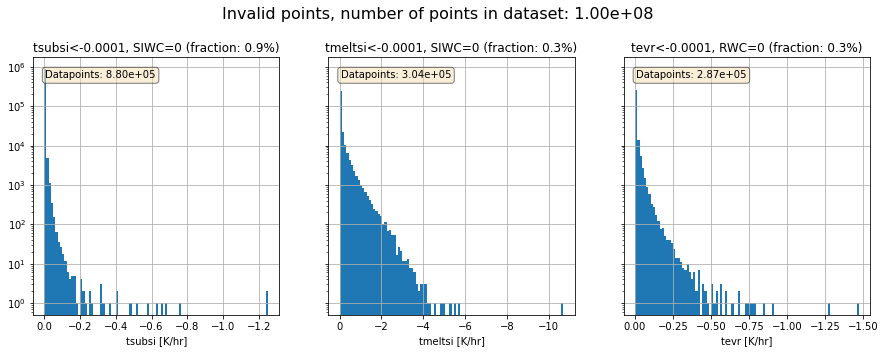

In [4]:
### INSPECT WEIRD FORBIDDEM VALUES (no water content but bcp)
tsubsi_forbidden = df_train.tsubsi[(df_train.tsubsi < -0.0001) & (df_train.SIWC == 0)]
tmeltsi_forbidden = df_train.tmeltsi[(df_train.tmeltsi < -0.0001) & (df_train.SIWC == 0)]
tevr_forbidden = df_train.tevr[(df_train.tevr < -0.0001) & (df_train.RWC == 0)]

fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)

ax[0].hist(tsubsi_forbidden, log=True, bins=100)
ax[0].grid(True)
ax[0].invert_xaxis()

ax[1].hist(tmeltsi_forbidden, log=True, bins=100)
ax[1].grid(True)
ax[1].invert_xaxis()

ax[2].hist(tevr_forbidden, log=True, bins=100)
ax[2].grid(True)
ax[2].invert_xaxis()

ax[0].set_title(f'tsubsi<-0.0001, SIWC=0 (fraction: {(tsubsi_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[0].set_xlabel('tsubsi [K/hr]')
# Add datapoint count in a text box for the first plot
ax[0].text(0.05, 0.95, f'Datapoints: {tsubsi_forbidden.shape[0]:2.2e}', transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[1].set_title(f'tmeltsi<-0.0001, SIWC=0 (fraction: {(tmeltsi_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[1].set_xlabel('tmeltsi [K/hr]')
# Add datapoint count in a text box for the second plot
ax[1].text(0.05, 0.95, f'Datapoints: {tmeltsi_forbidden.shape[0]:2.2e}', transform=ax[1].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[2].set_title(f'tevr<-0.0001, RWC=0 (fraction: {(tevr_forbidden.shape[0] / df_train.shape[0])*100:.1f}%)')
ax[2].set_xlabel('tevr [K/hr]')
# Add datapoint count in a text box for the third plot
ax[2].text(0.05, 0.95, f'Datapoints: {tevr_forbidden.shape[0]:2.2e}', transform=ax[2].transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle(f'Invalid points, number of points in dataset: {df_train.shape[0]:.2e}', fontsize=16)
plt.subplots_adjust(top=0.84)
plt.show()


In [5]:
cols_target_features = ['tmeltsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']  

df_train = df_train[cols_target_features]
df_val = df_val[cols_target_features]

In [6]:
df_train.describe()

,tmeltsi,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07
mean,-3.257633e-03,6.646162e-03,2.504825e-03,6.648872e-04,1.274297e+01,3.822144e-04,-1.977584e-02,-1.104258e+01
std,5.525999e-02,4.433433e-02,1.935200e-02,9.133182e-03,2.570297e+01,1.276379e-03,1.570743e-01,1.916656e+01
min,-1.071278e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.261989e+01,-9.121857e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.286819e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.414006e+00,3.436481e-06,0.000000e+00,0.000000e+00
max,0.000000e+00,6.370396e+00,1.511991e+00,2.368629e+00,1.362414e+02,2.178455e-02,9.686302e+00,4.174277e+01


In [7]:
print(df_train.shape)
print(df_val.shape)

(99952833, 8)
(14438680, 8)


In [9]:
df_tmeltsi_train = rf_functions.apply_domainfilter(df=df_train,
                                                   water_type='SIWC',
                                                   verbose=1,
                                                   temp_filter=True,
                                                   output_filter=False)

Drop all points where SIWC == 0 and Temp < 0


In [11]:
df_tmeltsi_val = rf_functions.apply_domainfilter(df=df_val,
                                                 water_type='SIWC',
                                                 verbose=2,
                                                 temp_filter=True,
                                                 output_filter=False)

Drop all points where SIWC == 0 and Temp < 0
Filtered dataframe size:	1.76e+05 	1.2% of size compared to unfiltered. (Points dropped: 14263074)

	No categories for tmeltsi available! Creating labels and stats now...

Class 0 fraction (before drop):	99.4%

Class Balance New Dataframe:
------------------------------
Class 0 fraction:	58.5%		 102758 Points
Class 1 fraction:	33.8%		  59269 Points
Class 2 fraction:	 7.7%		  13579 Points
------------------------------		--------------
Toatal points in new df:		 175606 Points



In [12]:
if 'tmeltsi' in df_val.columns:
    print('si')

si


In [13]:
# Define the predictors and the target
target = 'tmeltsi'

X_train = df_tmeltsi_train.drop([target], axis=1)
y_train = df_tmeltsi_train[target]

X_val = df_tmeltsi_val.drop([target], axis=1)
y_val = df_tmeltsi_val[target]

In [14]:
list(X_train.columns)

['SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']

In [15]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

In [16]:
filepath_mse = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tmeltsi/full_data_girdsearch_tmeltsi_mse.joblib"
filepath_f1  = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tmeltsi/full_data_girdsearch_tmeltsi_f1.joblib"

if (os.path.isfile(filepath_mse) or os.path.isfile(filepath_f1)) and input('Rerun model? (y/n)') == 'n':
    print('Load Model')
    best_model_f1 = joblib.load(filepath_f1)
else:
    doublecheck = input('Do you want to run the model?  (yes/no)')
    if doublecheck == 'yes':

        param_grid = {
            'n_estimators': [800,],
            'max_depth': [150],
            'max_features': [4,5,6],
            'min_samples_split': [5],
            'min_samples_leaf':[10,15,25],
            'criterion': ['squared_error']
        }
        best_model_mse, best_params_mse, best_model_f1, best_params_f1 = rf_functions.grid_search_with_validation_set_f1(X_train=X_train,
                                                                                                            y_train=y_train, 
                                                                                                            X_val=X_val, 
                                                                                                            y_val=y_val, 
                                                                                                            param_grid=param_grid,
                                                                                                            save_name='full_data_girdsearch_tmeltsi'
                                                                                                            )

Load Model


In [80]:
best_model_f1

RandomForestRegressor(max_depth=150, max_features=5, min_samples_leaf=10,
                      min_samples_split=5, n_estimators=800, n_jobs=60)

In [17]:
# Predict using your validation set
y_pred = best_model_f1.predict(X_val)

In [18]:
# Create confusion matrix
thr_weak   = -0.075
thr_strong = -0.75

def discreticise_labels(array, thr1, thr2=None):
    
    labeled_array = np.zeros_like(array)
    if thr2 is not None:
        for i, val in enumerate(array):
            if val > thr1:
                labeled_array[i] = 0
            elif thr1 >= val > thr2:
                labeled_array[i] = 1
            elif val <= thr2:
                labeled_array[i] = 2
    else:
        for i, val in enumerate(array):
            if val > thr1:
                labeled_array[i] = 0
            else:
                labeled_array[i] = 1
    return labeled_array

y_pred_discrete = discreticise_labels(y_pred, thr1=thr_weak, thr2=thr_strong)
y_actual_discrete = discreticise_labels(y_val, thr1=thr_weak, thr2=thr_strong)
cm = rf_functions.get_confmat_clasreport(y_actual_discrete, y_pred_discrete, model='Test')

============================  Test  ============================
Confusion matrix:
[[95365  7286   107]
 [ 2917 54518  1834]
 [    0  2393 11186]]

	------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    102758
         1.0       0.85      0.92      0.88     59269
         2.0       0.85      0.82      0.84     13579

    accuracy                           0.92    175606
   macro avg       0.89      0.89      0.89    175606
weighted avg       0.92      0.92      0.92    175606



In [20]:
residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)



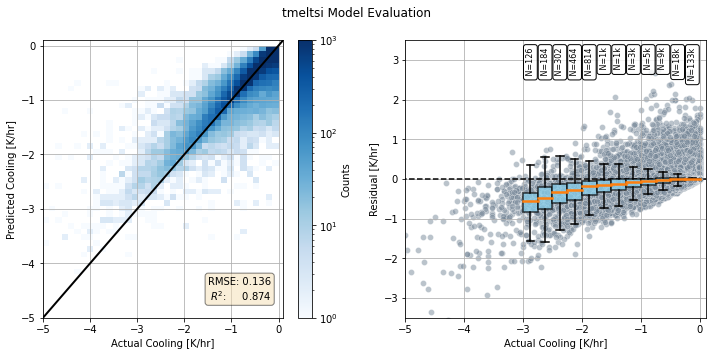

In [21]:
process = 'tmeltsi'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle(f'{process} Model Evaluation')

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Cooling [K/hr]')
ax[0].set_ylabel('Predicted Cooling [K/hr]')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)
ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')

# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Counts')
# Set logarithmic colorbar ticks 
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
# cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.3f}\n$R^2$:     {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.95, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           ha='right', va='top', bbox=props)
ax[0].grid(zorder=0)
# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, alpha=0.5, color='lightslategray', ax=ax[1])
ax[1].set_xlabel('Actual Cooling [K/hr]')
ax[1].set_ylabel('Residual [K/hr]')
ax[1].set_xlim(-5, 0.1)
ax[1].set_ylim(-3.5, 3.5)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plot_helpers.add_boxplots(x=y_val,y=residuals, ax=ax[1], width_boxplot=0.25, min_points_boxplot=100, count_per_boxplot=True, fontsize_text=8, input_detail_mode=False)
plt.tight_layout()
plt.grid(zorder=0)
# plt.savefig(f'/home/freimax/msc_thesis/figures/random_forest/IFS/{process}/trueVSpred_residual_plot.png',dpi=200)

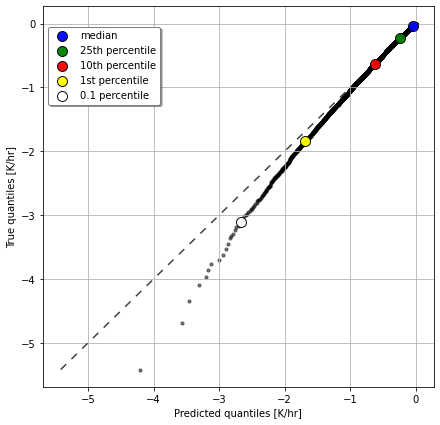

In [22]:
# Generate the plot
y_pred = best_model_f1.predict(X_val)
fig, ax = plt.subplots(figsize=(7,7))
nr_points = plot_helpers.plot_modified_qq_plot(ax=ax, y_pred=y_pred, y_true=y_val, subsample_factor=0.1)
plt.show()

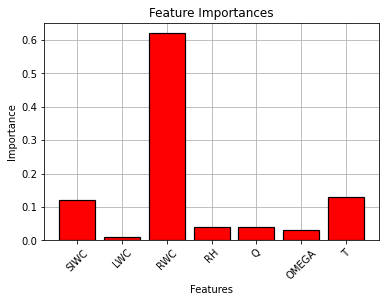

In [78]:
# Get numerical feature importances
importances = list(best_model_f1.feature_importances_)

# List of tuples with variable and importance and sort them
feature_list = list(X_train.columns) 
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# list of x locations for plotting
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

x_values = list(range(len(importances)))# Make a bar chart
plt.grid(zorder=0)
plt.bar(x_values, sorted_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2, zorder=2)
plt.xticks(x_values, sorted_features, rotation=45)# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Feature Importances')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tmeltsi_feat_imp'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')

---

In [25]:
from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)
from sklearn.inspection import plot_partial_dependence


In [51]:
feature_indices = [feature_list.index(feature) for feature in ['SIWC','RWC','T']] 
feature_indices

[0, 2, 6]

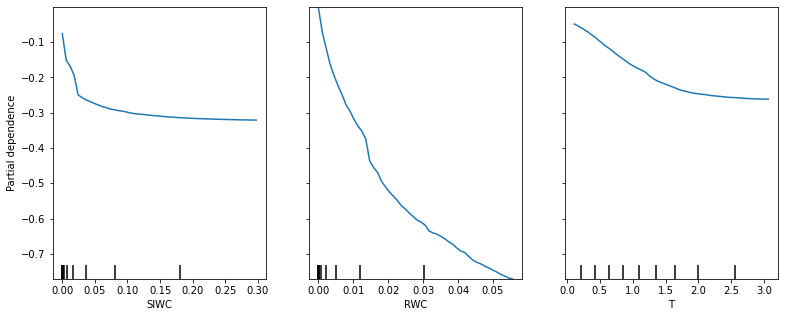

In [57]:
fig,axs = plt.subplots(nrows=1,ncols=3, figsize=(13,5), sharey=True)

imgs = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices, grid_resolution=50, ax=axs)
for i in [1,2]:
    axs[i].set_ylabel('')
# PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices[1], grid_resolution=50, ax=ax[1])
# PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices[2], grid_resolution=50, ax=ax[2])



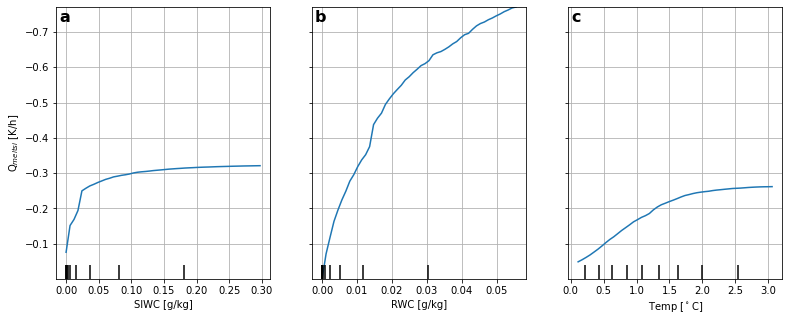

In [79]:
xlabel_list = ['SIWC [g/kg]', 'RWC [g/kg]', r'Temp [$^\circ$C]']

fig,axs = plt.subplots(nrows=1,ncols=3, figsize=(13,5), sharey=True)
imgs = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices, grid_resolution=50, ax=axs)

axs[0].set_ylabel(r'Q$_{meltsi}$ [K/h]')
for i in range(3):
    if i !=0:
        axs[i].set_ylabel('')
    axs[i].set_xlabel(xlabel_list[i])
    axs[i].invert_yaxis()


## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tmeltsi_pdp_single'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()


In [60]:
# Get index of all important features
imp_feat_dx = [feature_list.index(feature) for feature in ['SIWC','RWC','T']] 
# Generating all possible combinations of 2 features from the list of 7 features
feature_combinations = list(combinations(imp_feat_dx, 2))
feature_combinations 

[(0, 2), (0, 6), (2, 6)]

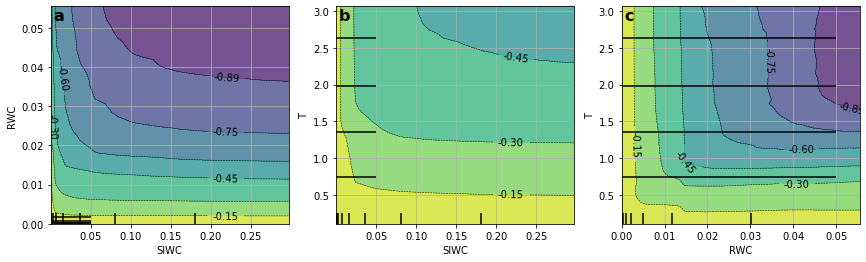

In [74]:
if len(feature_combinations)<=3:
    cols = int(len(feature_combinations))
    fig,axs=plt.subplots(ncols=cols, figsize=(4.5*cols+1,4))
else:
    cols = len(feature_combinations) // 2
    rows = len(feature_combinations) - cols
    fig,axs=plt.subplots(nrows=int(rows), ncols=int(cols), figsize=(5*cols,5*rows))

imgs2d = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_combinations, ax=axs,
                                        grid_resolution=50, feature_names=feature_list)

## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tmeltsi_pdp_2feat'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# if len(feature_combinations)<=3:
#     cols = int(len(feature_combinations))
#     fig,axs=plt.subplots(ncols=cols, figsize=(4*cols+1,4))
# else:
#     cols = len(feature_combinations) // 2
#     rows = len(feature_combinations) - cols
#     fig,axs=plt.subplots(nrows=int(rows), ncols=int(cols), figsize=(5*cols,5*rows))

# imgs = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_combinations, ax=axs,
#                                         grid_resolution=50, feature_names=feature_list)


In [73]:
imgs.deciles_hlines_

array([<matplotlib.collections.LineCollection object at 0x7fbfa8c53e50>,
      dtype=object)

SIWC


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


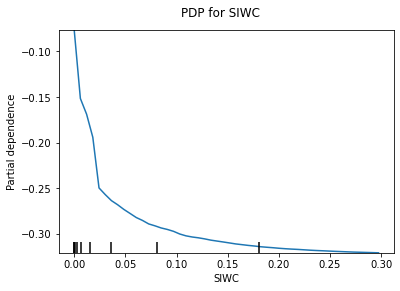

LWC


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


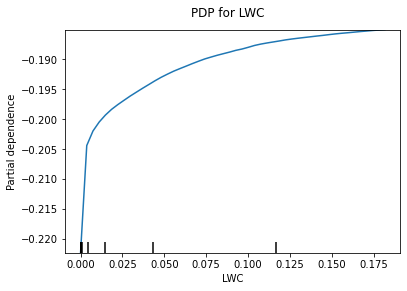

RWC


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


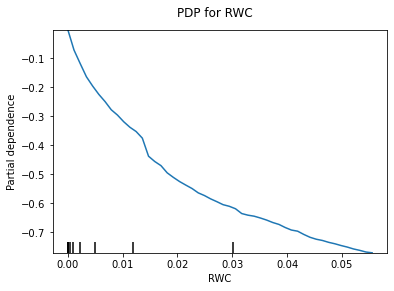

RH


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


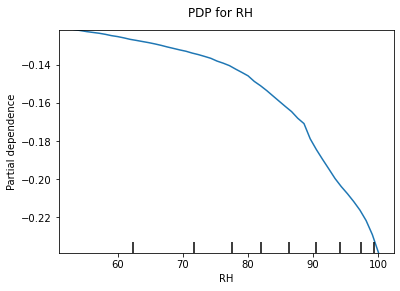

Q


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


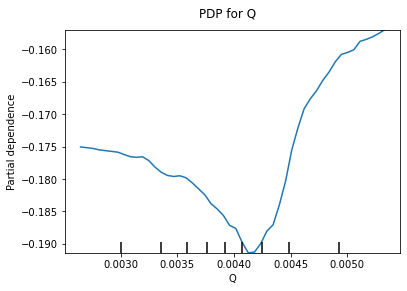

OMEGA


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


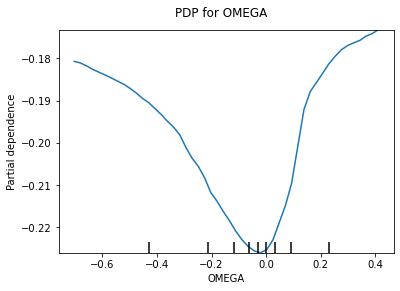

T


/usr/local/Miniconda3-envs/envs/2022/envs/iacpy3_2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


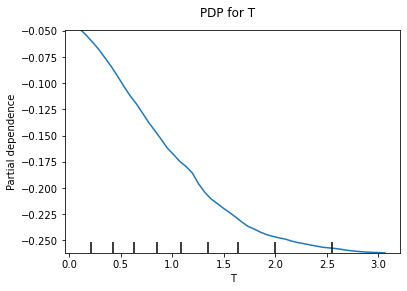

In [28]:


# Plotting PDP for each feature
for feature_name in feature_list:
    feature_index = feature_list.index(feature_name)
    print(feature_name)
    plot_partial_dependence(best_model_f1, X_train, feature_list, grid_resolution=50)
    plt.suptitle(f'PDP for {feature_name}')
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()


In [38]:
feature_list

['SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']

(0, 2)


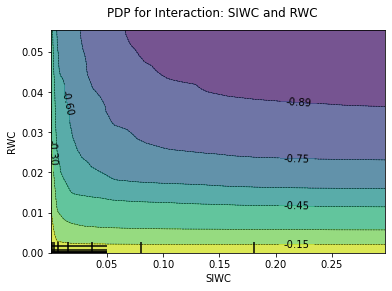

(0, 6)


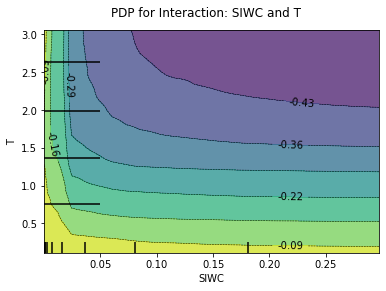

(2, 6)


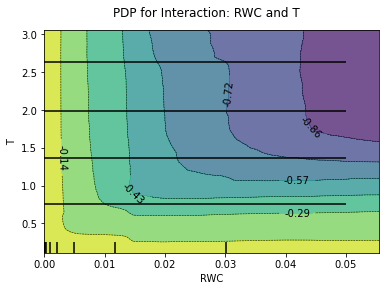

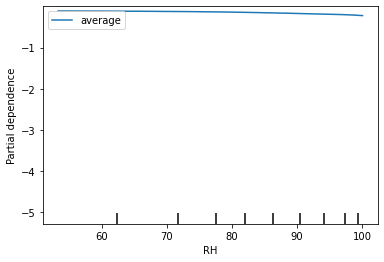

---

In [146]:
def plot_rel_frequ_histogram(data, ax=None, log=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create an array of bin edges with a step size of 0.1
    data_min = np.floor(data.min() * 10) / 10
    data_max = np.ceil(data.max() * 10) / 10
    bins = np.arange(data_min, data_max + 0.1, 0.25)

    # Create weights array
    weights = np.ones_like(data) / len(data)

    # Plot histogram with custom bins and weights
    ax.hist(data, bins=bins, zorder=2, weights=weights, log=log)
    # ax.set_xlabel('Cooling value [K/hr]')
    ax.set_ylabel('Relative Frequency of total data')
    ax.invert_xaxis()
    ax.grid(zorder=0)

    data_size = data.shape[0]
    
    ax.text(0.95, 0.95, f'Data Size: {data_size:.1e}', 
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

## Transform data, suhc that tmeltsi is only positive and greater than 10
def transform_y(df, y_name='tmeltsi'):
    """Applies a transformation to a DataFrame column: negates and adds 10."""
    df = df.copy()  # avoid modifying original dataframe
    df[y_name] = -df[y_name] + 10
    return df

def inverse_transform_y(df, y_name='tmeltsi'):
    """Inverse transformation for the 'transform_col' function."""
    df = df.copy()  # avoid modifying original dataframe
    
    if len(df.shape) == 1:
        df = -(df - 10)
    else:
        df[y_name] = -(df[y_name] - 10)
    return df

---
## SMOGN

Tackle imbalanced dataset:
- First find a reasonable cooling-threshold to cut-off dataset
- Apply SMOGN to subset (ONLY TRAINING DATA)
- Train model on subset that tries to predict validation subset (note: validation set is also cut-off with trheshold, but SMOGN is NOT applied)

In [46]:
import smogn

In [35]:
thr_list = [-0.0001, -0.001, -0.01, -0.1, -0.25, -0.5]

points_df_train = []
for thr in thr_list:
    points_df_train.append(df_tmeltsi_train[df_tmeltsi_train.tmeltsi <= thr].shape[0])

Text(0.5, 1.0, 'Total Points (filtered data): 1.7e+06')

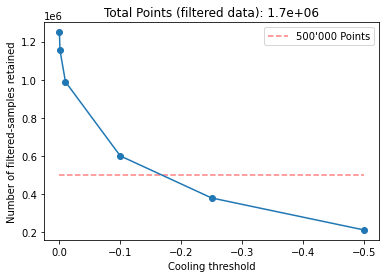

In [125]:
plt.plot(thr_list, points_df_train, marker='o',zorder=1)
plt.hlines(5e5, thr_list[0], thr_list[-1], linestyles='--', color='r',zorder=0, alpha=0.5, label="500'000 Points")
plt.xlabel('Cooling threshold')
plt.ylabel('Number of filtered-samples retained')
plt.gca().invert_xaxis()
plt.legend()
plt.title(f'Total Points (filtered data): {df_tmeltsi_train.shape[0]:2.1e}')

In [43]:
df_train_thr = df_tmeltsi_train[df_tmeltsi_train.tmeltsi < -0.1]
df_val_thr = df_tmeltsi_val[df_tmeltsi_val.tmeltsi < -0.1]

In [164]:
df_train_thr_sample = df_train_thr.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_train_thr_sample.describe()

,tmeltsi,SIWC,RH,Q,CC,OMEGA,T
count,60043.000000,6.004300e+04,60043.000000,60043.000000,60043.000000,60043.000000,60043.000000
mean,-0.519086,1.049124e-01,90.985802,0.004317,0.348400,-0.151964,1.428146
std,0.495143,1.642128e-01,10.125047,0.000706,0.408408,0.529693,0.885284
min,-5.981549,9.313226e-07,14.903340,0.001508,0.000000,-9.067025,0.000214
25%,-0.665916,8.281320e-03,85.494919,0.003871,0.000000,-0.245587,0.755783
50%,-0.344661,4.184246e-02,94.380959,0.004187,0.085938,-0.063918,1.273712
75%,-0.187510,1.341267e-01,98.945553,0.004630,0.820312,0.020714,1.918335
max,-0.100000,3.448661e+00,111.871155,0.009012,1.000000,5.049186,8.878693


In [167]:
df_train_thr_sample_trans = transform_y(df_train_thr_sample, y_name='tmeltsi')
df_train_thr_sample_trans.describe()

,tmeltsi,SIWC,RH,Q,CC,OMEGA,T
count,60043.000000,6.004300e+04,60043.000000,60043.000000,60043.000000,60043.000000,60043.000000
mean,10.519180,1.049124e-01,90.985802,0.004317,0.348400,-0.151964,1.428146
std,0.495142,1.642128e-01,10.125047,0.000706,0.408408,0.529693,0.885284
min,10.100000,9.313226e-07,14.903340,0.001508,0.000000,-9.067025,0.000214
25%,10.187510,8.281320e-03,85.494919,0.003871,0.000000,-0.245587,0.755783
50%,10.344661,4.184246e-02,94.380959,0.004187,0.085938,-0.063918,1.273712
75%,10.665915,1.341267e-01,98.945553,0.004630,0.820312,0.020714,1.918335
max,15.981548,3.448661e+00,111.871155,0.009012,1.000000,5.049186,8.878693


In [57]:
df_train_thr_sample_trans_smogn = smogn.smoter(data=df_train_thr_sample_trans,
                                               y='tmeltsi')

r_index: 100%|##########| 950/950 [00:00<00:00, 1606.75it/s]


In [168]:
df_train_thr_sample_trans_smogn_k10 = smogn.smoter(data=df_train_thr_sample_trans,
                                               k=10,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_k100 = smogn.smoter(data=df_train_thr_sample_trans,
                                               k=100,
                                               y='tmeltsi')


r_index: 100%|##########| 9638/9638 [00:06<00:00, 1585.80it/s]


Text(0.5, 1.0, 'k=100')

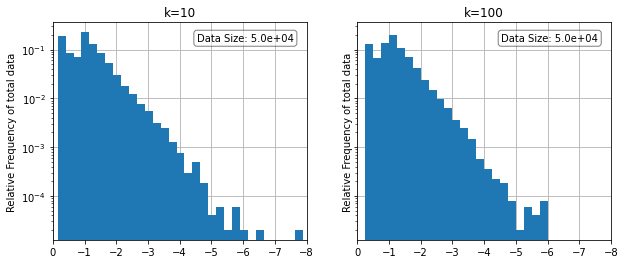

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5*2,4), sharey=True, sharex=False)
ax[0].set_xlim(-8,0)
ax[1].set_xlim(-8,0)
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_k10, y_name='tmeltsi')['tmeltsi'] , ax=ax[0], log=True)
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_k100, y_name='tmeltsi')['tmeltsi'], ax=ax[1], log=True)
ax[0].set_title('k=10')
ax[1].set_title('k=100')

In [169]:
df_train_thr_sample_trans_smogn_025 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_thres=0.25,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_075 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_thres=0.75,
                                               y='tmeltsi')

r_index: 100%|##########| 1065/1065 [00:00<00:00, 1580.55it/s]


ValueError: oops! synthetic data contains missing values

In [ ]:
df_train_thr_sample_trans_smogn_090 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_thres=0.90,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_095 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_thres=0.95,
                                               y='tmeltsi')


r_index: 100%|##########| 496/496 [00:00<00:00, 1622.84it/s]


In [ ]:
df_train_thr_sample_trans_smogn_coef1 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=1,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_coef2 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=2,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_coef3 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=3,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_coef4 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=4,
                                               y='tmeltsi')

r_index: 100%|##########| 23/23 [00:00<00:00, 1573.72it/s]


In [ ]:
df_train_thr_sample_trans_smogn_pert01 = smogn.smoter(data=df_train_thr_sample_trans,
                                               pert=0.1,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_pert02 = smogn.smoter(data=df_train_thr_sample_trans,
                                               pert=0.2,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_pert05 = smogn.smoter(data=df_train_thr_sample_trans,
                                               pert=0.5,
                                               y='tmeltsi')
df_train_thr_sample_trans_smogn_pert09 = smogn.smoter(data=df_train_thr_sample_trans,
                                               pert=0.9,
                                               y='tmeltsi')

r_index: 100%|##########| 950/950 [00:00<00:00, 1605.49it/s]


In [ ]:
df_train_thr_sample_trans_smogn_mix1 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=1,
                                               k=100,
                                               rel_thres=0.75,
                                               pert=0.9,
                                               y='tmeltsi')

df_train_thr_sample_trans_smogn_mix2 = smogn.smoter(data=df_train_thr_sample_trans,
                                               rel_coef=1,
                                               k=500,
                                               rel_thres=0.75,
                                               pert=0.9,
                                               y='tmeltsi')

r_index: 100%|##########| 62/62 [00:00<00:00, 1380.83it/s]


Text(0.5, 1.0, 'k=500,rel_thres=0.75,pert=0.9')

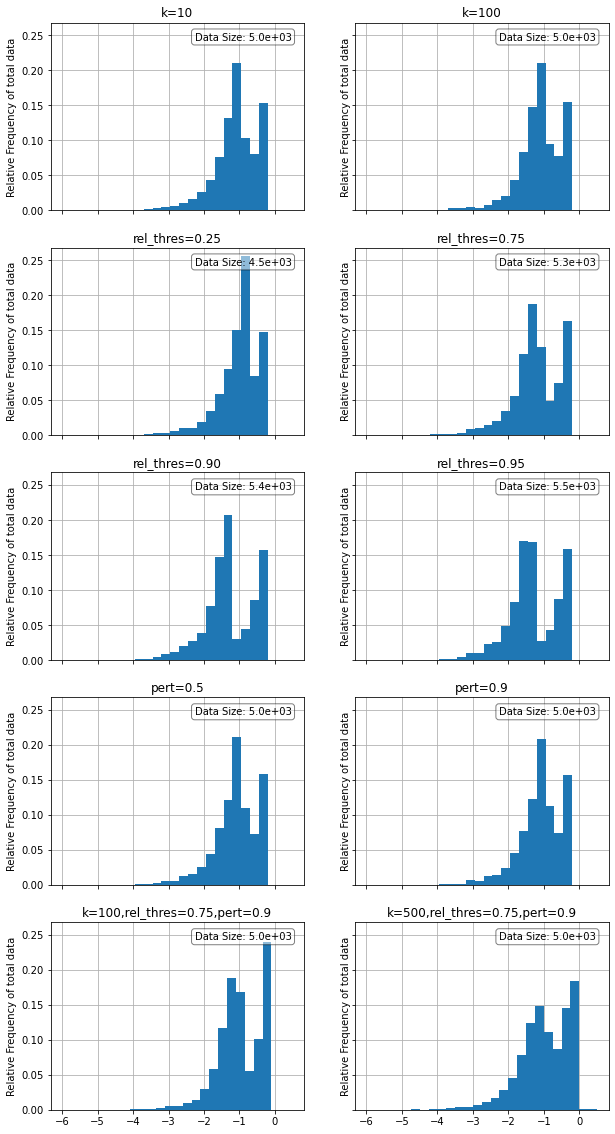

In [ ]:
nrows=5
ncols=2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols,4*nrows), sharey=True, sharex=True)
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_k10, y_name='tmeltsi')['tmeltsi'] , ax=ax[0,0])
ax[0,0].set_title('k=10')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_k100, y_name='tmeltsi')['tmeltsi'], ax=ax[0,1])
ax[0,1].set_title('k=100')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_025, y_name='tmeltsi')['tmeltsi'] , ax=ax[1,0])
ax[1,0].set_title('rel_thres=0.25')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_075, y_name='tmeltsi')['tmeltsi'] , ax=ax[1,1])
ax[1,1].set_title('rel_thres=0.75')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_090, y_name='tmeltsi')['tmeltsi'] , ax=ax[2,0])
ax[2,0].set_title('rel_thres=0.90')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_095, y_name='tmeltsi')['tmeltsi'] , ax=ax[2,1])
ax[2,1].set_title('rel_thres=0.95')

plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_pert05, y_name='tmeltsi')['tmeltsi'] , ax=ax[3,0])
ax[3,0].set_title('pert=0.5')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_pert09, y_name='tmeltsi')['tmeltsi'] , ax=ax[3,1])
ax[3,1].set_title('pert=0.9')

plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_mix1, y_name='tmeltsi')['tmeltsi'] , ax=ax[4,0])
ax[4,0].set_title('k=100,rel_thres=0.75,pert=0.9')
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_mix2, y_name='tmeltsi')['tmeltsi'] , ax=ax[4,1])
ax[4,1].set_title('k=500,rel_thres=0.75,pert=0.9')



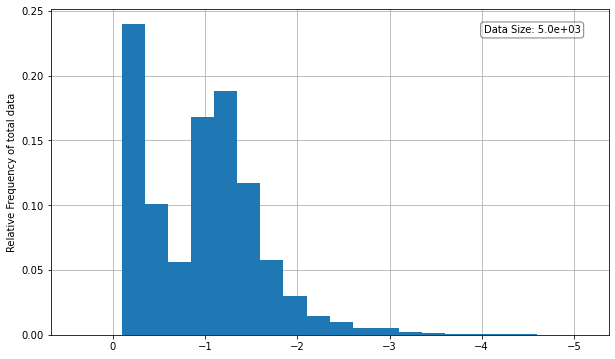

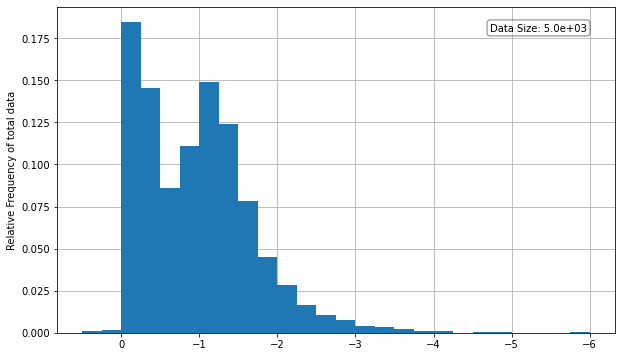

In [ ]:
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_mix1, y_name='tmeltsi')['tmeltsi'] , log=False)
plot_rel_frequ_histogram(data=inverse_transform_y(df_train_thr_sample_trans_smogn_mix2, y_name='tmeltsi')['tmeltsi'] , log=False)


In [156]:
df_train_smogn = inverse_transform_y(df_train_thr_sample_trans_smogn_mix2, y_name='tmeltsi')

target = 'tmeltsi'
X_train_smogn = df_train_smogn.drop([target], axis=1)
y_train_smogn = df_train_smogn[target]

X_train_nosmogn = df_train_thr_sample.drop([target], axis=1) 
y_train_nosmogn = df_train_thr_sample[target]

X_val_smogn = df_val_thr.drop([target], axis=1)
y_val_smogn = df_val_thr[target]

In [157]:
## Check with a baseline model (no smogn applied)
param_grid = {
    'n_estimators': [800,],
    'max_depth': [50],
    'max_features': [6],
    'min_samples_split': [10,],
    'min_samples_leaf':[1],
    'criterion': ['squared_error']
}
best_model_mse, best_params_mse, best_model_f1, best_params_f1 = rf_functions.grid_search_with_validation_set_f1(X_train=X_train_nosmogn,
                                                                                                    y_train=y_train_nosmogn, 
                                                                                                    X_val=X_val_smogn, 
                                                                                                    y_val=y_val_smogn, 
                                                                                                    param_grid=param_grid,
                                                                                                    save_name='trash/nosmogn_baselinge_tmeltsi',
                                                                                                    threshold=-1
                                                                                                    )

Target variable is: tmeltsi

Start Grid-Search:
Model   1 of   1 | n_estiM = 800 | max_depth = 50 | max_features =  6 | min_samp_split = 10| min_samp_leaf = 1 | crit = squared_error | precision: 0.872  | recall: 0.845 | F1: 0.8575  |  RMSE: 0.2795  (NEW BEST F1 AND RMSE)

Best parameters based on MSE: {'n_estimators': 800, 'max_depth': 50, 'max_features': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
Best MSE: 0.07810994968285881  -->  Best RMSE: 0.2794815730649497

Best parameters based on F1: {'n_estimators': 800, 'max_depth': 50, 'max_features': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
Best F1: 0.8575365620407301


FileNotFoundError: [Errno 2] No such file or directory: '/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tmeltsi/trash/nosmogn_baselinge_tmeltsi_mse.joblib'

In [163]:
param_grid = {
    'n_estimators': [800,],
    'max_depth': [50,100],
    'max_features': [4,6],
    'min_samples_split': [5,15],
    'min_samples_leaf':[1,5],
    'criterion': ['squared_error', 'absolute_error']
}
best_model_mse, best_params_mse, best_model_f1, best_params_f1 = rf_functions.grid_search_with_validation_set_f1(X_train=X_train_smogn,
                                                                                                    y_train=y_train_smogn, 
                                                                                                    X_val=X_val_smogn, 
                                                                                                    y_val=y_val_smogn, 
                                                                                                    param_grid=param_grid,
                                                                                                    save_name='trash/nosmogn_baselinge_tmeltsi',
                                                                                                    threshold=-1
                                                                                                    )

Target variable is: tmeltsi

Start Grid-Search:
Model   1 of  32 | n_estiM = 800 | max_depth = 50 | max_features =  4 | min_samp_split =  5| min_samp_leaf = 1 | crit = squared_error | precision: 0.811  | recall: 0.904 | F1: 0.8465  |  RMSE: 0.3200  (NEW BEST F1 AND RMSE)
Model   4 of  32 | n_estiM = 800 | max_depth = 50 | max_features =  4 | min_samp_split =  5| min_samp_leaf = 5 | crit = absolute_error | precision: 0.813  | recall: 0.906 | F1: 0.8489  |  RMSE: 0.3171  (NEW BEST F1 AND RMSE)
Model   8 of  32 | n_estiM = 800 | max_depth = 50 | max_features =  4 | min_samp_split = 15| min_samp_leaf = 5 | crit = absolute_error | precision: 0.814  | recall: 0.907 | F1: 0.8497  |  RMSE: 0.3173  (NEW BEST F1)
Current Model: 10 of of  32
Current Model: 20 of of  32
Current Model: 30 of of  32

Best parameters based on MSE: {'n_estimators': 800, 'max_depth': 50, 'max_features': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}
Best MSE: 0.10056169585543613  -->  

In [159]:
y_pred = best_model_f1.predict(X_val_smogn)

Root Mean Squared Error (RMSE): 0.32041861176047604
R-squared: 0.629555996616169


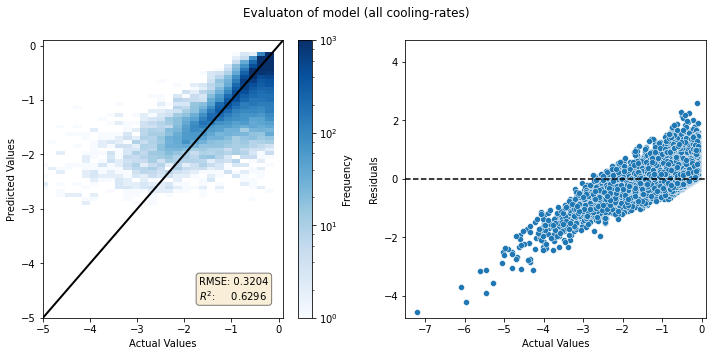

In [161]:
import matplotlib.colors as colors


y_val = y_val_smogn

threshold=-0.1
f1 = f1_score((y_val >= threshold), (y_pred >= threshold), average='macro')

residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.suptitle('Evaluaton of model (all cooling-rates)')
# Scatter plot with hist2d
hist = ax[0].hist2d(y_val, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/home/freimax/msc_thesis/figures/random_forest/IFS/tmeltsi/grid_search_model_cutoff_f1_{f1:.3f}.png',dpi=150)

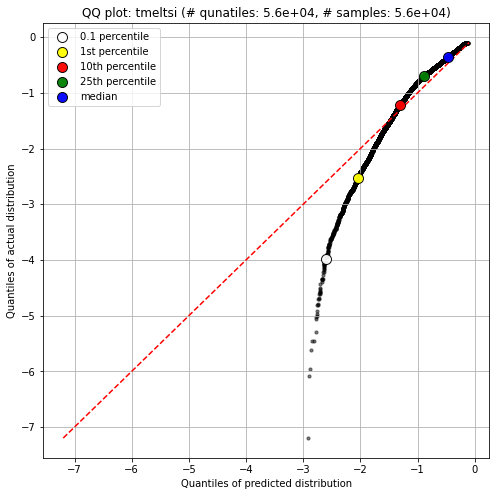

In [162]:
y_val = y_val_smogn
# Calculate the percentiles
y_pred_sorted = np.sort(y_pred)
y_val_sorted = np.sort(y_val)

# Generate percentiles
nr_points = len(y_pred)
percentiles = np.linspace(0, 100, nr_points ) 

# Calculate the Q-Q pairs
q_pred = np.percentile(y_pred_sorted, percentiles)
q_val = np.percentile(y_val_sorted, percentiles)
# Generate the plot
plt.figure(figsize=(8,8))
plt.scatter(q_pred, q_val, color='k', s=10, alpha=0.5)


# Mark median and other percentiles
p01_pred = np.percentile(q_pred, 0.1)
p01_val = np.percentile(q_val, 0.1)
plt.scatter(p01_pred, p01_val, color='white', edgecolor='k', label='0.1 percentile', s=100, zorder=5, alpha=0.95)

p1_pred = np.percentile(q_pred, 1)
p1_val = np.percentile(q_val, 1)
plt.scatter(p1_pred, p1_val, color='yellow', edgecolor='k', label='1st percentile', s=100, zorder=5, alpha=0.95)

p10_pred = np.percentile(q_pred, 10)
p10_val = np.percentile(q_val, 10)
plt.scatter(p10_pred, p10_val, color='red', edgecolor='k', label='10th percentile', s=100, zorder=5, alpha=0.95)

p25_pred = np.percentile(q_pred, 25)
p25_val = np.percentile(q_val, 25)
plt.scatter(p25_pred, p25_val, color='green', edgecolor='k', label='25th percentile', s=100, zorder=5, alpha=0.95)

median_pred = np.median(q_pred)
median_val = np.median(q_val)
plt.scatter(median_pred, median_val, color='blue', edgecolor='k', label='median', s=100, zorder=5, alpha=0.95)



# Diagonal line
plt.plot([np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 
         [np.min((q_pred.min(),q_val.min())), np.max((q_pred.max(),q_val.max()))], 'r--')

plt.xlabel('Quantiles of predicted distribution')
plt.ylabel('Quantiles of actual distribution')
plt.title(f'QQ plot: tmeltsi (# qunatiles: {nr_points:2.1e}, # samples: {len(y_pred):2.1e})')
plt.grid(True)
plt.legend() 
plt.show()

---
---
#### From here are models that i tried to run, but that were not prmising
#### Following methods were tried:
- Scale target variable (with log)
- Regression + Classification model (Here i only tried to use a threshold to cut-off the data that is used for regression, this cut would be learned by regression)

---
---
## Try Regression model after classification model

In [73]:
def apply_cooling_thr(X,y, thr):
    X_cutoff = X[y <= thr]
    y_cutoff = y[y <= thr]
    assert X_cutoff.shape[0] == y_cutoff.shape[0]
    print(f'New shape:\t{X_cutoff.shape }\t\tOld shape:\t{X.shape}')
    return X_cutoff, y_cutoff

In [74]:
param_grid2 = {
    'n_estimators': [1000],
    'max_depth': [30],
    'max_features': [2],
    'min_samples_split': [30, 40],
    'min_samples_leaf':[7],
    'criterion': ['squared_error']
}


cutoff_models = []
cutoff_params = []
thr_list = [-0.1, -0.01, -0.001, -0.0001]
for thr in thr_list:
    print(f'\n\nCooling cutoff: {thr}')
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    # Call the function
    cutoff_model, cutoff_param = grid_search_with_validation_set(X_train=X_train_cutoff,
                                                                y_train=y_train_cutoff, 
                                                                X_val=X_val_cutoff, 
                                                                y_val=y_val_cutoff, 
                                                                param_grid=param_grid2,
                                                                save_name=f'cutoff_{thr}_tmeltsi'
                                                                )
    cutoff_models.append(cutoff_model)
    cutoff_params.append(cutoff_param)



Cooling cutoff: -0.1
New shape:	(1204720, 5)		Old shape:	(3993401, 5)
New shape:	(117142, 5)		Old shape:	(390989, 5)

Start Grid-Search:
Model   1 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 30| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.26914  (NEW BEST)

Best parameters: {'n_estimators': 1000, 'max_depth': 30, 'max_features': 2, 'min_samples_split': 30}
Best MSE: 0.07243571234267424  -->  Best RMSE: 0.2691388346981428


Cooling cutoff: -0.01
New shape:	(1887901, 5)		Old shape:	(3993401, 5)
New shape:	(181413, 5)		Old shape:	(390989, 5)

Start Grid-Search:
Model   1 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 30| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.23588  (NEW BEST)
Model   2 of   2 | n_estimators =1000 | max_depth = 30 | max_features =  2 | min_samples_split = 40| min_samples_leaf = 7 | criterion = squared_error | RMSE: 0.23583  (NEW BEST)

Best parameters: {

In [75]:
# Predict using your validation set
y_pred = big_model.predict(X_val_cutoff)

assert y_pred.shape[0] == y_val_cutoff.shape[0]

Root Mean Squared Error (RMSE): 0.21913111362715043
R-squared: 0.7777665369341814


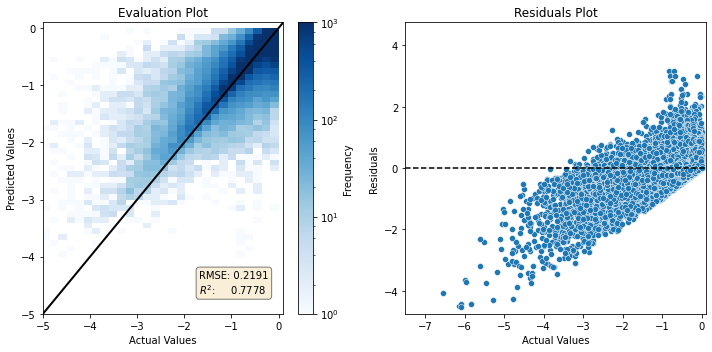

In [76]:
import matplotlib.colors as colors

residuals = y_val_cutoff - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val_cutoff, y_pred))
r2 = r2_score(y_val_cutoff, y_pred)

# Print out the metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val_cutoff, y_pred, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val_cutoff, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals Plot')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/net/helium/atmosdyn/freimax/figures/random_forest/IFS/tmeltsi/single_forest_noscale/tmeltsi_cutoff_model_rmse_{rmse:.3f}.png',dpi=150)

In [77]:
thr_list = [-0.1, -0.01, -0.001, -0.0001]

rmse_co_list = []
r2_co_list = []

for i, thr in enumerate(thr_list):
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    
    y_pred_CO = cutoff_models[i].predict(X_val_cutoff)

    # Calculate metrics
    rmse_co_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_CO)))
    r2_co_list.append(r2_score(y_val_cutoff, y_pred_CO))




New shape:	(1204720, 5)		Old shape:	(3993401, 5)
New shape:	(117142, 5)		Old shape:	(390989, 5)
New shape:	(1887901, 5)		Old shape:	(3993401, 5)
New shape:	(181413, 5)		Old shape:	(390989, 5)
New shape:	(2160321, 5)		Old shape:	(3993401, 5)
New shape:	(206264, 5)		Old shape:	(390989, 5)
New shape:	(2315031, 5)		Old shape:	(3993401, 5)
New shape:	(220149, 5)		Old shape:	(390989, 5)


In [78]:
y_pred_full = big_model.predict(X_val)
threshold_list = np.arange(-0.0001,-1, -0.001)#[-0.1, -0.01, -0.005, -0.001, -0.0001]

rmse_list =[]
r2_list = []
for i,thr in enumerate(threshold_list):
    y_val_cutoff = y_val[y_val<=thr] 
    y_pred_full_cutoff = y_pred_full[y_val<=thr]

    rmse_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_full_cutoff)))
    r2_list.append(r2_score(y_val_cutoff, y_pred_full_cutoff))
    
    if (i+1) % 100 == 0:
        print(f'Done with step {i} of {threshold_list.shape[0]}')

Done with step 99 of 1000
Done with step 199 of 1000
Done with step 299 of 1000
Done with step 399 of 1000
Done with step 499 of 1000
Done with step 599 of 1000
Done with step 699 of 1000
Done with step 799 of 1000
Done with step 899 of 1000
Done with step 999 of 1000


/tmp/ipykernel_55607/2939554271.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim(-0.01, 0.15)


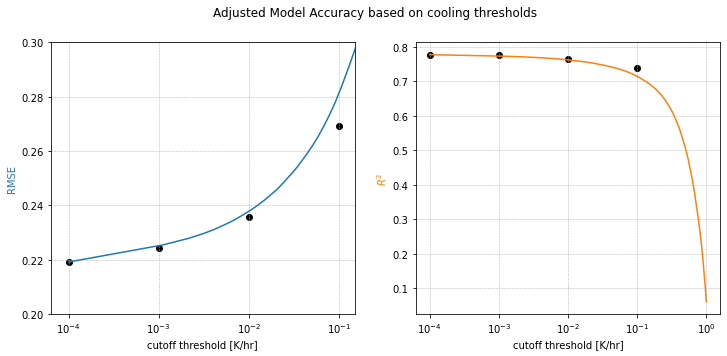

In [79]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Adjusted Model Accuracy based on cooling thresholds', fontsize=12)

ax[0].plot(-threshold_list, rmse_list, c='#1f77b4')
#ax[0].invert_xaxis()
ax[0].set_xlabel('cutoff threshold [K/hr]')
ax[0].set_ylabel('RMSE', c='#1f77b4', fontsize=10)
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(0.2, 0.3)
ax[0].set_xlim(-0.01, 0.15)

ax[1].plot(-threshold_list, r2_list, c='#ff7f0e')
#ax[1].invert_xaxis()
ax[1].set_ylabel(r'$R^2$', c='#ff7f0e', fontsize=10)
ax[1].set_xlabel('cutoff threshold [K/hr]')
ax[1].set_xscale('log')

ax[0].scatter([-x for x in thr_list], rmse_co_list, c='k')
ax[1].scatter([-x for x in thr_list], r2_co_list, c='k')

# Adding grid lines
for axes in ax:
    if axes.get_xscale() == 'log':
        axes.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        axes.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        axes.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=150))
    else:
        axes.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

plt.show()


In [80]:
y_val_cutoff = y_val[y_val<=-0.1] 
y_pred_full_cutoff = y_pred_full[y_val<=-0.1]
y_pred_CO = cutoff_models[-1].predict(X_val_cutoff)


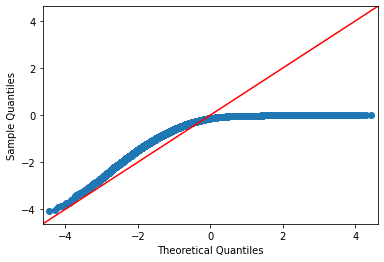

In [81]:
import statsmodels.api as sm
import pylab as py
sm.qqplot(y_pred_CO, line ='45')
py.show()